In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_alexnet_model(input_shape, num_classes):
    model = models.Sequential()

    # Layer 1
    model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 2
    model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 3
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Layer 4
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Layer 5
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Flatten and fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

input_shape = (224, 224, 3) 
num_classes = 5

alexnet_model = create_alexnet_model(input_shape, num_classes)

alexnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 26, 26, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 12, 12, 256)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 12, 384)       885120    
                                                                 
 conv2d_18 (Conv2D)          (None, 12, 12, 384)      

To include in the below cell in case performance is bad



In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adadelta

def get_ImageDataGenerator_augmented(learning_rate, validation_split=None):
    image_generator = ImageDataGenerator(rescale=(1/255.),
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.1,
                                        brightness_range=[0.8,1.2],
                                        horizontal_flip=True,
                                        validation_split=validation_split)
    return image_generator, learning_rate

data_folder = 'data/horse_photos'
pretrained_size = (224,224)
batch_size = 20

learning_rate = 1.0  # Adadelta doesn't use learning rate like other optimizers

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, 
                             validation_split=0.3) 

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42)

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42)

classnames = list(train_generator.class_indices.keys())
print("class names: ", classnames)

# Compile your model with Adadelta optimizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
output = Dense(len(classnames), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adadelta(), loss='categorical_crossentropy', metrics=['accuracy'])


Getting Data...
Preparing training dataset...
Found 1329 images belonging to 5 classes.
Preparing validation dataset...
Found 568 images belonging to 5 classes.
class names:  ['AmericanBashkirCurly', 'AmericanPaintHorse', 'BelgianDraft', 'Friesian', 'ShetlandPony']


In [24]:
from tensorflow.keras.optimizers import Adadelta

# Compile your model with Adadelta optimizer
alexnet_model.compile(optimizer=Adadelta(), loss='categorical_crossentropy', metrics=['accuracy'])

num_epochs = 28

history = alexnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // batch_size,
    epochs=num_epochs)

Epoch 1/48
265/265 [==============================] - 156s 586ms/step - loss: 1.6109 - accuracy: 0.2002 - val_loss: 1.6072 - val_accuracy: 0.2142
Epoch 2/48
265/265 [==============================] - 157s 594ms/step - loss: 1.6062 - accuracy: 0.2296 - val_loss: 1.6046 - val_accuracy: 0.2796
Epoch 3/48
265/265 [==============================] - 263s 994ms/step - loss: 1.6034 - accuracy: 0.2379 - val_loss: 1.6031 - val_accuracy: 0.2920
Epoch 4/48
265/265 [==============================] - 302s 1s/step - loss: 1.6013 - accuracy: 0.2530 - val_loss: 1.6010 - val_accuracy: 0.2177
Epoch 5/48
265/265 [==============================] - 298s 1s/step - loss: 1.6011 - accuracy: 0.2470 - val_loss: 1.5999 - val_accuracy: 0.2195
Epoch 6/48
265/265 [==============================] - 296s 1s/step - loss: 1.5958 - accuracy: 0.2704 - val_loss: 1.5984 - val_accuracy: 0.2212
Epoch 7/48
265/265 [==============================] - 298s 1s/step - loss: 1.5965 - accuracy: 0.2644 - val_loss: 1.5972 - val_accurac

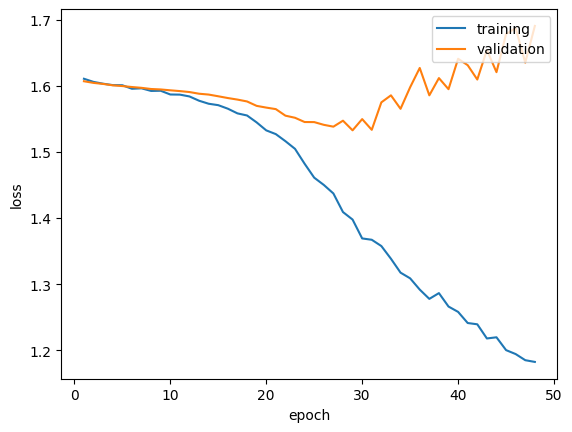

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [26]:
modelFileName = 'models/horses_28epochs_Adadelta_AlexNet.keras'
alexnet_model.save(modelFileName)
del alexnet_model  # deletes the existing model variable
print('model saved as', modelFileName)

c:\Users\jeanp\OneDrive\Desktop\Thesis Environment\ipcv-env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


model saved as models/horses_48epochs_Adadelta_AlexNet.h5


Generating predictions from validation data...
1/1 [==============================] - 0s 399ms/step


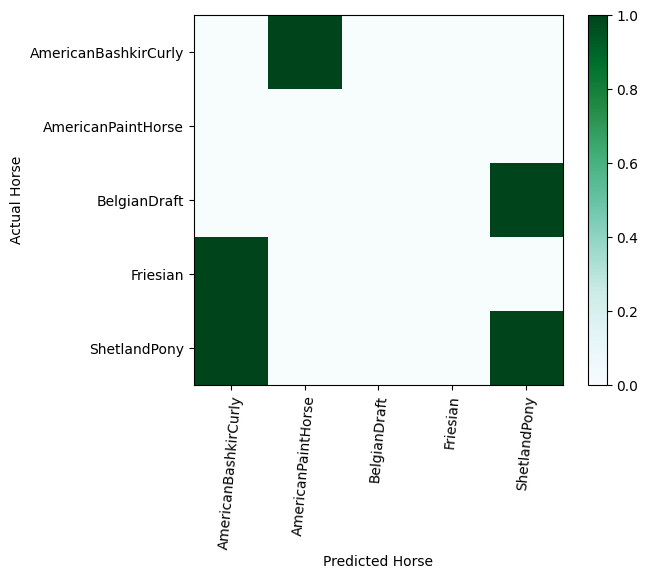

In [27]:

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import keras
%matplotlib inline

model = keras.models.load_model('models/horses_28epochs_Adadelta_AlexNet.keras')

print("Generating predictions from validation data...")
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

class_probabilities = model.predict(x_test)

predictions = np.argmax(class_probabilities, axis=1)

true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap = plt.cm.BuGn)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Horse")
plt.ylabel("Actual Horse")
plt.show()

In [28]:
import os
import numpy as np
import tensorflow
from  tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

model = keras.models.load_model('models/horses_28epochs_Adadelta_AlexNet.keras')



# 2. Load and preprocess the images from the folder
image_folder = './inferencing'
image_files = os.listdir(image_folder)



# Set image size to match your model's input shape
img_width, img_height = 224, 224



# Preprocess images and store them in a list
preprocessed_images = []
for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array)
    preprocessed_images.append(img_preprocessed)



# 3. Perform inference on the preprocessed images
predictions = [model.predict(img) for img in preprocessed_images]


classnames = os.listdir(os.path.join('data/horse_photos'))
classnames.sort()

for i, img_file in enumerate(image_files):
    index = int(np.argmax(predictions[i], axis=1)[0])
    print(f"Prediction for {img_file}: {predictions[i]} Class:{classnames[index]}")

1/1 [==============================] - 0s 117ms/step
Prediction for ABC1.jpg: [[0. 0. 0. 1. 0.]] Class:Friesian
Prediction for ABC2.jpg: [[0. 0. 0. 1. 0.]] Class:Friesian
Prediction for ABC3.jpg: [[0. 0. 0. 1. 0.]] Class:Friesian
Prediction for ABC4.jpg: [[0. 0. 0. 1. 0.]] Class:Friesian
Prediction for AP1.jpg: [[0.        0.9984364 0.        0.0015636 0.       ]] Class:AmericanPaintHorse
Prediction for AP2.jpg: [[0. 0. 0. 1. 0.]] Class:Friesian
Prediction for AP3.jpg: [[0. 1. 0. 0. 0.]] Class:AmericanPaintHorse
Prediction for AP4.jpg: [[0. 0. 0. 1. 0.]] Class:Friesian
Prediction for BD1.jpg: [[0. 0. 0. 1. 0.]] Class:Friesian
Prediction for BD2.jpg: [[0. 0. 0. 1. 0.]] Class:Friesian
Prediction for BD3.jpg: [[0. 0. 0. 1. 0.]] Class:Friesian
Prediction for BD4.jpg: [[0. 0. 0. 1. 0.]] Class:Friesian
Prediction for F1.jpg: [[0. 0. 0. 1. 0.]] Class:Friesian
Prediction for F2.jpg: [[0. 0. 0. 1. 0.]] Class:Friesian
Prediction for F3.jpg: [[0. 0. 0. 1. 0.]] Class:Friesian
Prediction for F4.jpg